In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import re
import time

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'
dataset_file = 'filtered_dataset.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)

# Creare l'istanza del modello ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-06 16:50:53.473762: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 16:50:53.473927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 16:50:53.474965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 16:50:53.479894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

### Create ResNet dataset

In [2]:
# Initialize new array
data = np.empty((len(dataset_array), 1+7+2048))  # ResNet50 output size is 2048

# Iterate over each row in the dataset
for i in range(len(dataset_array)):
    # Load image
    img_path = dataset_processed_path + str(dataset_array[i,0].astype(int)) + '.jpg'
    img = Image.open(img_path)
    img = img.resize((224, 224))  # ResNet50 expects 224x224 images
    img_data = kimage.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Compute global descriptor
    resnet_feature = resnet.predict(img_data)

    # Store data
    data[i,0] = dataset_array[i,0]
    data[i,1:8] = dataset_array[i,1:8]
    data[i,8:] = resnet_feature.squeeze()

# Save data
np.save(dataset_processed_path + 'resnet.npy', data)

2023-12-06 12:55:27.687164: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


1/1 [==============================] - 0s 18ms/step


### Plot filtered dataset

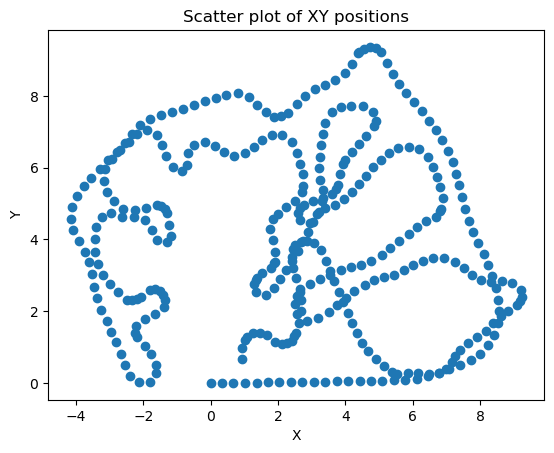

In [3]:
resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
positions = resnet_dataset[:, 1:3]

# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

# Image Retrieval

### TEST 1

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 525ms/step
Predict: 631.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 128.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 81.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Sum predict time:  0.8393335342407227
ResNet: 0.849 seconds


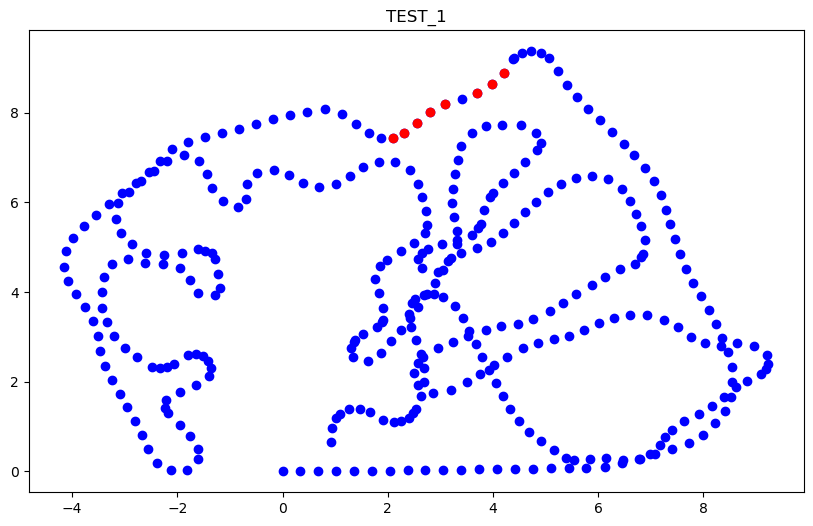

In [18]:
FILTER = True
N = 10
TEST = 'test_1'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 2

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 512ms/step
Predict: 617.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 82.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Sum predict time:  0.8239915370941162
ResNet: 0.834 seconds


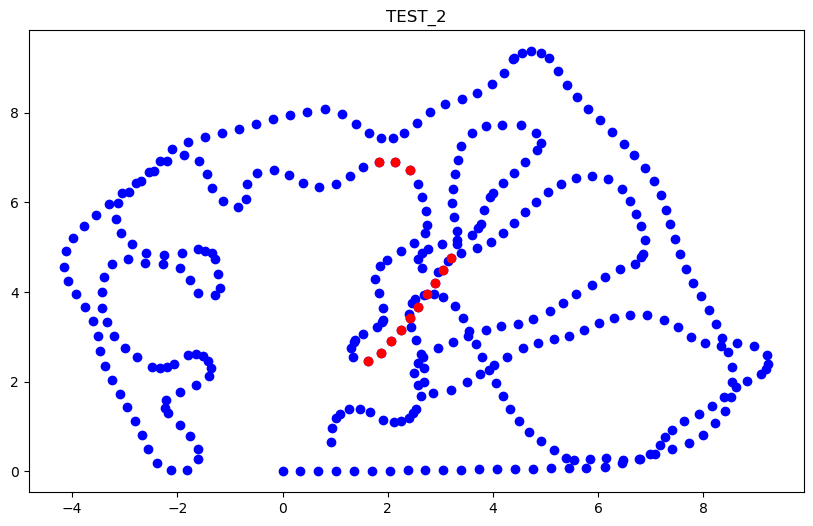

In [19]:
FILTER = True
N = 10
TEST = 'test_2'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 3

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 552ms/step
Predict: 657.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 53.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 56.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 57.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 31ms/step
Predict: 66.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============

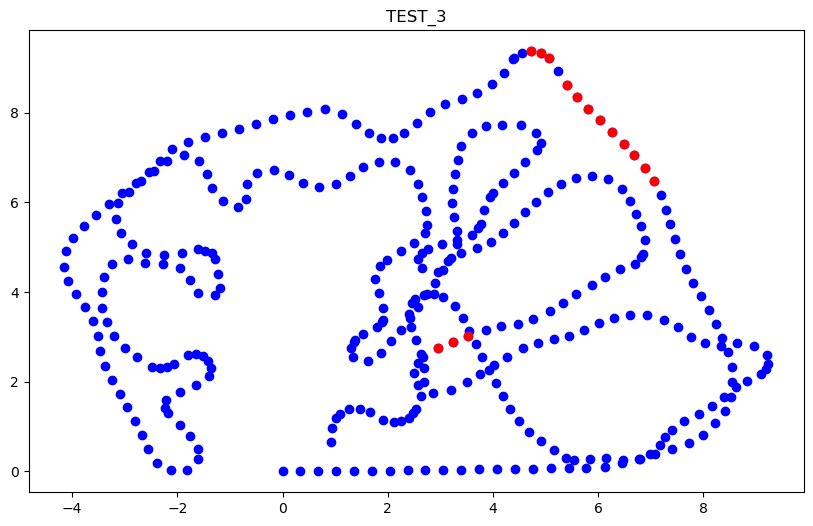

In [22]:
FILTER = True
N = 7
TEST = 'test_3'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 4

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 565ms/step
Predict: 679.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 126.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 127.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 124.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 89.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 82.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 85.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [=============

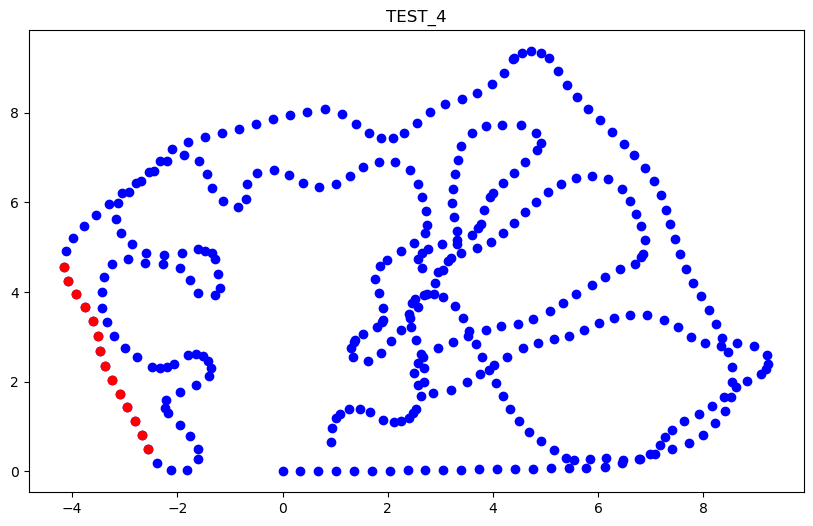

In [24]:
FILTER = True
N = 10
TEST = 'test_4'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 5

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 535ms/step
Predict: 639.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 127.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 122.0 ms
Similarities: 5.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 26ms/step
Predict: 62.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 36ms/step
Predict: 77.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 55.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 61.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============

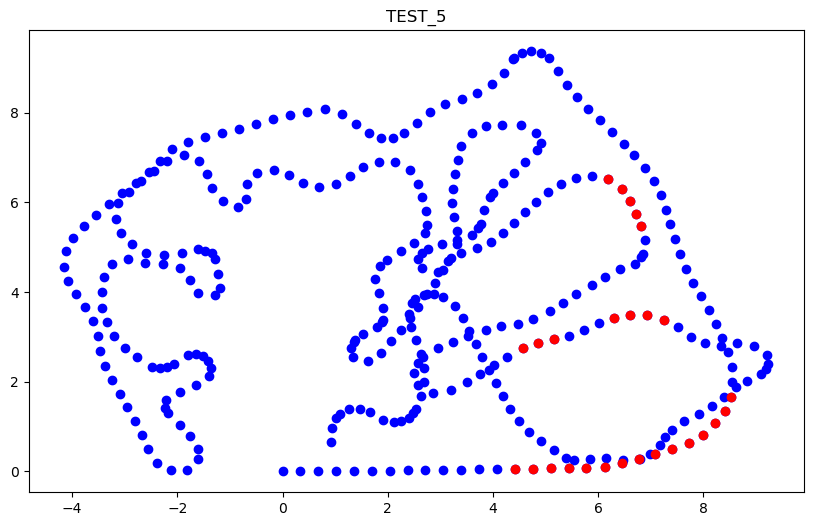

In [25]:
FILTER = True
N = 10
TEST = 'test_5'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.9, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 6

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 573ms/step
Predict: 682.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 29ms/step
Predict: 139.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 136.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 120.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 94.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 78.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 86.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [=============

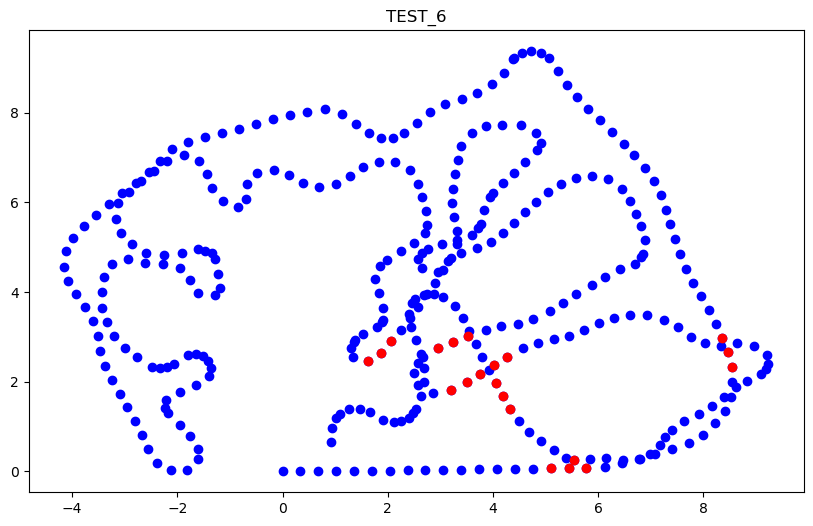

In [30]:
FILTER = True
N = 10
TEST = 'test_6'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=0.35, min_samples=3).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 7

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 566ms/step
Predict: 690.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 124.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 18ms/step
Predict: 121.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 90.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 80.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 82.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 82.0 ms
Similarities: 6.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============

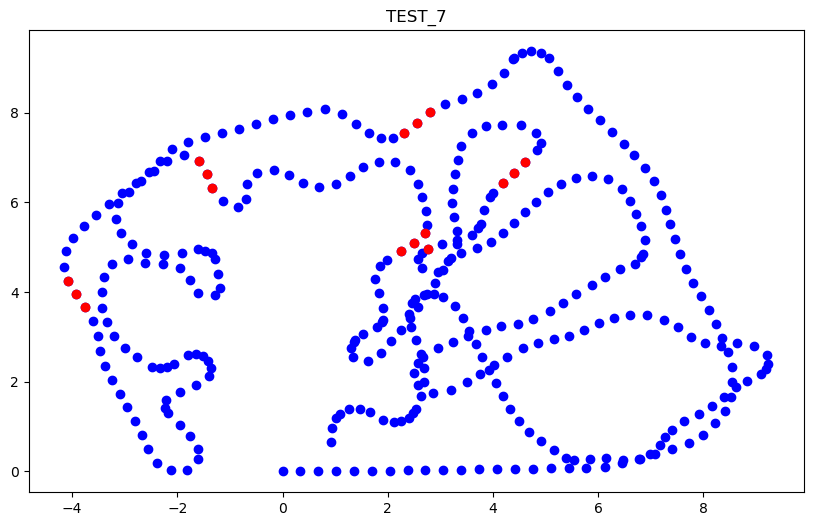

In [5]:
FILTER = True
EPSILON = 0.35
MIN_SAMPLES = 3
N = 10
TEST = 'test_7'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

# DATABASE v2

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from PIL import Image
from sklearn.cluster import DBSCAN
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image as kimage
import os
import re
import time

dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'
dataset_file = 'filtered_dataset_v2.npy'
dataset_array = np.load(dataset_processed_path + dataset_file)

# Creare l'istanza del modello ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-11 15:00:01.458972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 15:00:01.459041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 15:00:01.459713: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 15:00:01.465233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use 

### Create database ResNet v2

In [4]:
# Initialize new array
data = np.empty((len(dataset_array), 1+7+2048))  # VGG19 output size is 2048

# Iterate over each row in the dataset
for i in range(len(dataset_array)):
    # Load image
    img_name = f'image_{dataset_array[i,0].astype(int)}.jpg'
    img_path = os.path.join(dataset_processed_path, img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))  # VGG19 expects 224x224 images
    img_data = kimage.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    # Compute global descriptor
    resnet_feature = resnet.predict(img_data)

    # Store data
    data[i,0] = dataset_array[i,0]
    data[i,1:8] = dataset_array[i,1:8]
    data[i,8:] = resnet_feature.squeeze()

# Save data
np.save(dataset_processed_path + 'resnet.npy', data)

1/1 [==============================] - 0s 20ms/step


[[ 0.00000000e+00  1.26900955e-06 -1.88639280e-07 ...  7.91981041e-01
   0.00000000e+00  4.00097996e-01]
 [ 5.40000000e+01  2.95406354e-01 -4.50266366e-02 ...  8.30446720e-01
   1.45284921e-01  3.09121907e-01]
 [ 6.30000000e+01  6.03775132e-01 -1.02215713e-01 ...  7.50648439e-01
   2.89227832e-02  5.38344860e-01]]


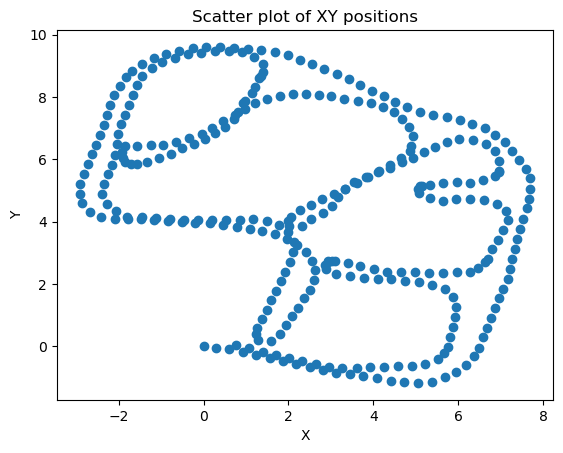

In [5]:
resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
positions = resnet_dataset[:, 1:3]
print(resnet_dataset[:3])
# Create scatter plot
plt.scatter(positions[:, 0], positions[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of XY positions')
plt.show()

# IMAGE RETRIEVAL

### TEST 1

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 507ms/step
Predict: 614.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 124.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 122.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 26ms/step
Predict: 85.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 82.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 105.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [============

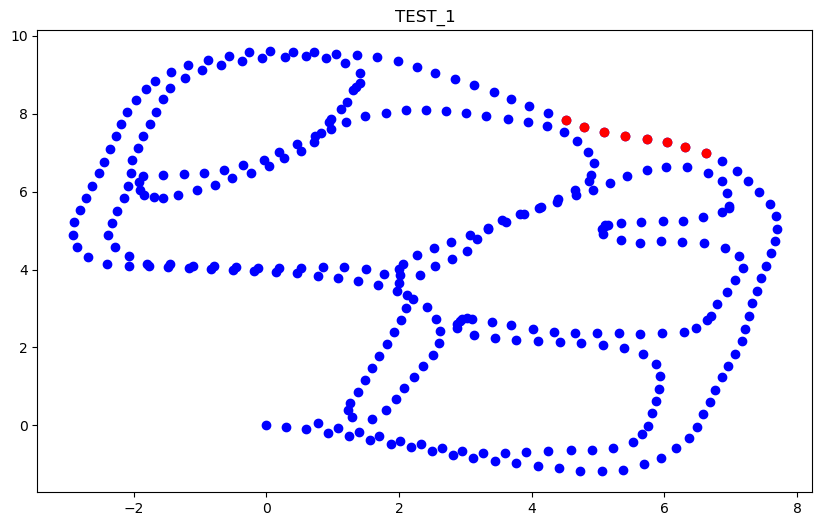

In [8]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_1'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 2

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 556ms/step
Predict: 674.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 124.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 80.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 83.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 29ms/step
Predict: 89.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [=============

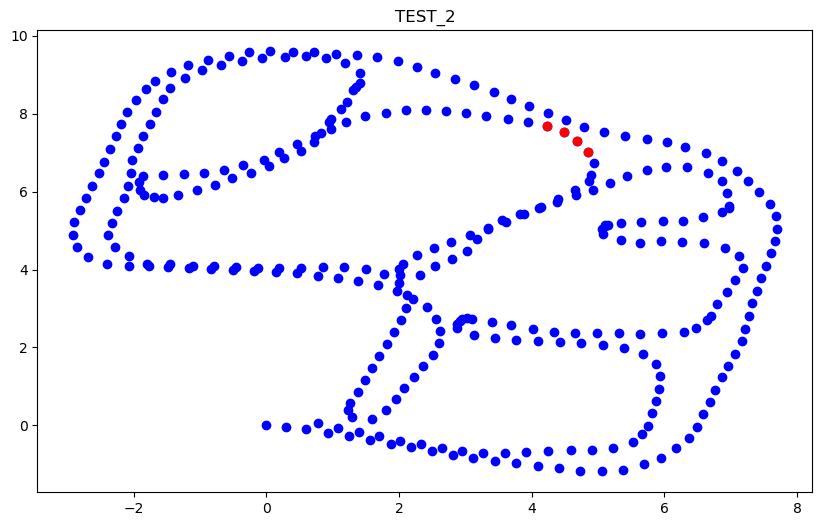

In [9]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_2'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 3

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 567ms/step
Predict: 676.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 129.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 26ms/step
Predict: 121.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 21ms/step
Predict: 103.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 80.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 86.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 91.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [=============

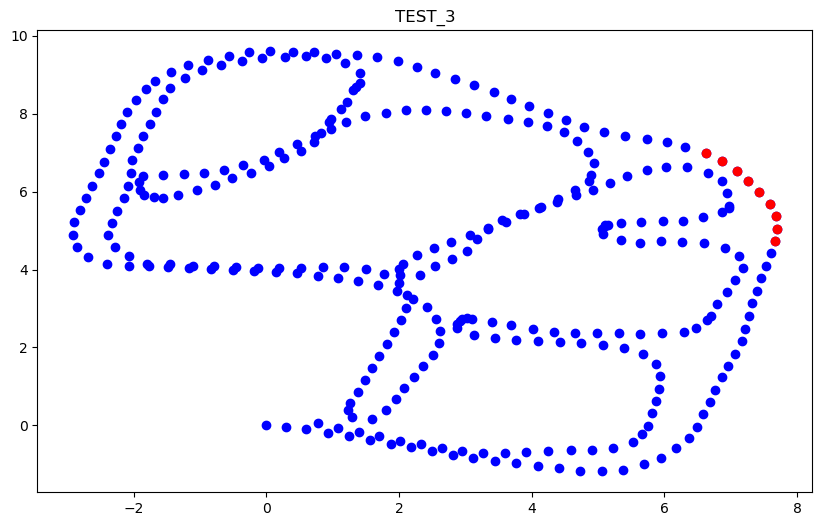

In [10]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_3'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 4

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 524ms/step
Predict: 639.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 19ms/step
Predict: 128.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 128.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 121.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 26ms/step
Predict: 109.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 91.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 87.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [============

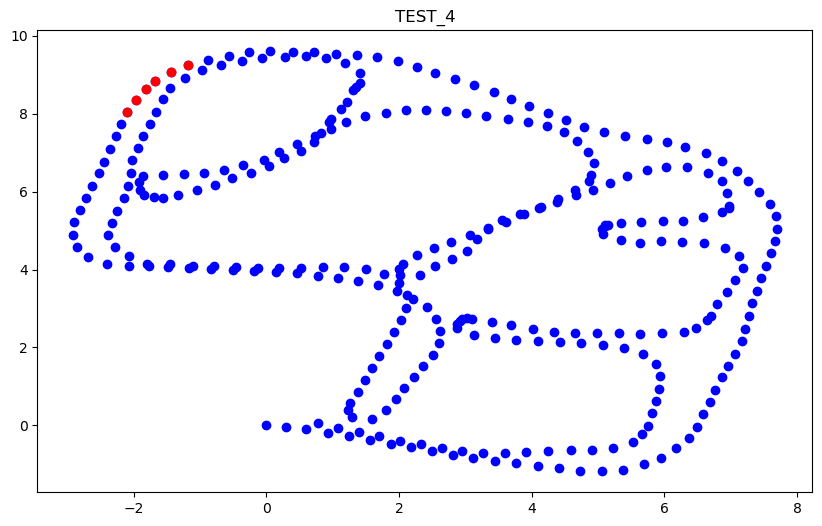

In [11]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_4'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 5

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 543ms/step
Predict: 653.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 1.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 126.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 128.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 127.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 87.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 80.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 24ms/step
Predict: 86.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [=============

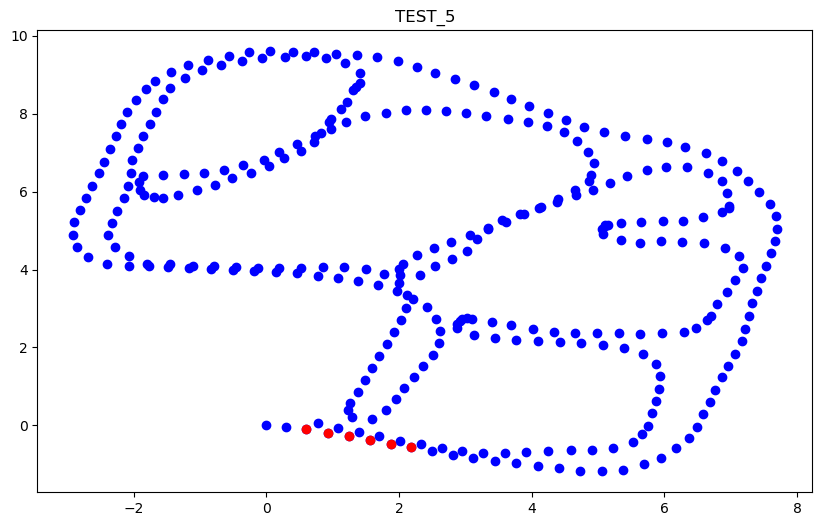

In [12]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_5'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)

### TEST 6

Preprocess input: 0.0 ms
1/1 [==============================] - 1s 568ms/step
Predict: 679.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 23ms/step
Predict: 125.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 118.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 27ms/step
Predict: 96.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 25ms/step
Predict: 92.0 ms
Similarities: 4.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 20ms/step
Predict: 94.0 ms
Similarities: 3.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============================] - 0s 22ms/step
Predict: 87.0 ms
Similarities: 2.0 ms
Top indices: 0.0 ms

Preprocess input: 0.0 ms
1/1 [==============

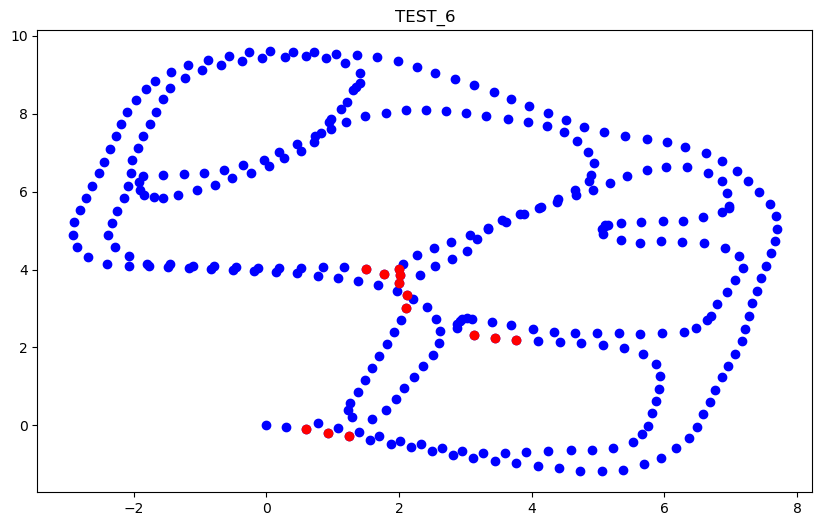

In [13]:
FILTER = True
EPS = 0.35
MIN_SAMPLES = 3
N = 5
TEST = 'test_6'
dataset_processed_path = '/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_processed_v2/'

def load_images(image_reloc_path):
    image_list = os.listdir(image_reloc_path)
    query_images_resnet = [kimage.load_img(image_reloc_path + image_name, target_size=(224, 224)) for image_name in image_list]
    return query_images_resnet

def process_resnet(query_images_resnet, resnet, resnet_dataset):
    top_indices_all_queries = []
    sum_predict_time = 0
    for image_reloc in query_images_resnet:
        
        start_time = time.time()
        img_data = preprocess_input(np.expand_dims(kimage.img_to_array(image_reloc), axis=0))
        end_time = time.time()
        print(f"Preprocess input: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        resnet_feature = resnet.predict(img_data)
        end_time = time.time()
        print(f"Predict: {round(end_time - start_time, 3)*1000} ms")
        sum_predict_time += end_time - start_time
        
        start_time = time.time()
        similarities = np.array([np.linalg.norm(resnet_feature - db_feature) for db_feature in resnet_dataset[:, 8:]])
        end_time = time.time()
        print(f"Similarities: {round(end_time - start_time, 3)*1000} ms")
        
        start_time = time.time()
        top_indices_all_queries.extend(similarities.argsort()[:N])
        end_time = time.time()
        print(f"Top indices: {round(end_time - start_time, 3)*1000} ms")
        print('')
        
    print('Sum predict time: ', sum_predict_time) 
    return list(set(top_indices_all_queries))

def filter_dbscan(filtered_dataset, top_indices_all_queries):
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(filtered_dataset[top_indices_all_queries][:, 1:3])
    return np.array(top_indices_all_queries)[clustering.labels_ != -1]

def plot_results(filtered_dataset, top_indices_all_queries):
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_dataset[:, 1], filtered_dataset[:, 2], color='blue')
    plt.scatter(filtered_dataset[top_indices_all_queries][:, 1], filtered_dataset[top_indices_all_queries][:, 2], color='red')
    plt.title(f'{TEST.upper()}')
    plt.show()

if __name__ == "__main__":
    # Initialize models and datasets
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    resnet_dataset = np.load(dataset_processed_path + 'resnet.npy')
    filtered_dataset = np.load(dataset_processed_path + 'filtered_dataset_v2.npy')

    # Load images
    image_reloc_path = f'/home/simone/tesi_ws/src/create_dataset/create_dataset/dataset_relocalization_v2/{TEST}/'
    query_images_resnet = load_images(image_reloc_path)

    # resnet processing
    start_time_resnet = time.time()
    top_indices_all_queries = process_resnet(query_images_resnet, resnet, resnet_dataset)

    # DBSCAN filtering
    if FILTER:
        top_indices_all_queries = filter_dbscan(filtered_dataset, top_indices_all_queries)
    end_time_resnet = time.time()

    # Print elapsed times
    print(f"ResNet: {round(end_time_resnet - start_time_resnet, 3)} seconds")

    # Plot results
    plot_results(filtered_dataset, top_indices_all_queries)
    #%timeit -r 2 -n 10 process_resnet(query_images_resnet, resnet, resnet_dataset)